
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
Artificial Intelligence <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
Spring 2024<br>
<font color=3C99D size=5>
Practical Assignment 1 - Local Search <br>
<font color=696880 size=4>
Ali Aghayari


____

# Personal Data

In [4]:
student_number = '400104801'
Name = 'Mehran'
Last_Name = 'Bakhtairi'

# Rules

<font color=red>
Please run all the cells.
</font>

# Libraries

In [5]:
pip install tsp_solver2

Note: you may need to restart the kernel to use updated packages.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import time
import itertools
from tsp_solver.greedy import solve_tsp

# Q1: TSP problem

## Problem Definition

Consider the Euclidean  [Traveling Salesperson Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem):</br>
- In this problem, we are considering a country with n cities that are randomly placed; our country is a 1000 by 1000 square; we want to find the shortest tour for this country using their coordinates.
- A tour is a cycle that passes each city precisely one time.
- In this notebook we will develop some solutions to the problem, and more generally show how to think about solving a problem like this.



## Problem Representation (20 Points)

 We want to create our problem structure and present some valuable methods in this part.
 - init: choose your problem structure and create the variables accordingly.
 - distance: take two cities and return the distance between them.
 - tour length: get a tour and return the length of the given tour.
 - The shortest tour: get a set of tours and return the shortest one.
 - plot tour: get a tour and plot tour of the country.
 - nearest_neighbor: get a semi-tour and return to the nearest city to the last element you have yet to visit.

In [1]:
class TSP:
    def __init__(self, num_cities, cities=None):
        if cities is None:
            self.num_cities = num_cities
            self.cities = np.random.rand(num_cities, 2) * 1000
        else:
            self.num_cities = len(cities)
            self.cities = cities

    def distance(self, A, B):
        city_A = self.cities[A]
        city_B = self.cities[B]
        return np.linalg.norm(city_B - city_A)

    def tour_length(self, tour):
        total_length = 0
        for i in range(len(tour)):
            total_length += self.distance(tour[i], tour[(i + 1) % len(tour)])
        return total_length

    def shortest_tour(self, tours):
        shortest_length = float('inf')
        shortest_tour = []
        for tour in tours:
            length = self.tour_length(tour)
            if length < shortest_length:
                shortest_length = length
                shortest_tour = tour
        return shortest_tour, shortest_length

    def plot_tour(self, tour):
        tour_cities = [self.cities[i] for i in tour]
        tour_cities.append(tour_cities[0])
        tour_cities = np.array(tour_cities)
        
        plt.figure(figsize=(8, 8))
        plt.plot(tour_cities[:, 0], tour_cities[:, 1], 'o-')
        plt.title('TSP Tour')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.grid(True)
        plt.show()

    def nearest_neighbor(self, A, cities, count=None):
        distances = [(i, self.distance(A, i)) for i in cities if i != A]
        distances.sort(key=lambda x: x[1])
        if count is None:
            return [distances[0][0]]
        else:
            return [distances[i][0] for i in range(min(count, len(distances)))]


## Brute Force (5 Points)

Let's start with an algorithm that is guaranteed to solve the problem (although it is inefficient for large sets of cities) </br>
we can achieve this by generating all possible tours of the cities and choosing the shortest tour (the one with minimum tour length).

In [2]:
def alltours_tsp(tsp):
    all_tours = itertools.permutations(range(tsp.num_cities))
    shortest_tour, shortest_length = tsp.shortest_tour(all_tours)
    return shortest_tour, shortest_length

Now, try to create a country with five cities and apply your brute force function to find the shortest tour.

In [7]:
tsp_country = TSP(num_cities=5)

shortest_tour, shortest_length = alltours_tsp(tsp_country)

print("Shortest Tour:", shortest_tour)
print("Shortest Length:", shortest_length)

Shortest Tour: (0, 2, 4, 1, 3)
Shortest Length: 2446.2137259463725


Visualize your answer for the TSP problem

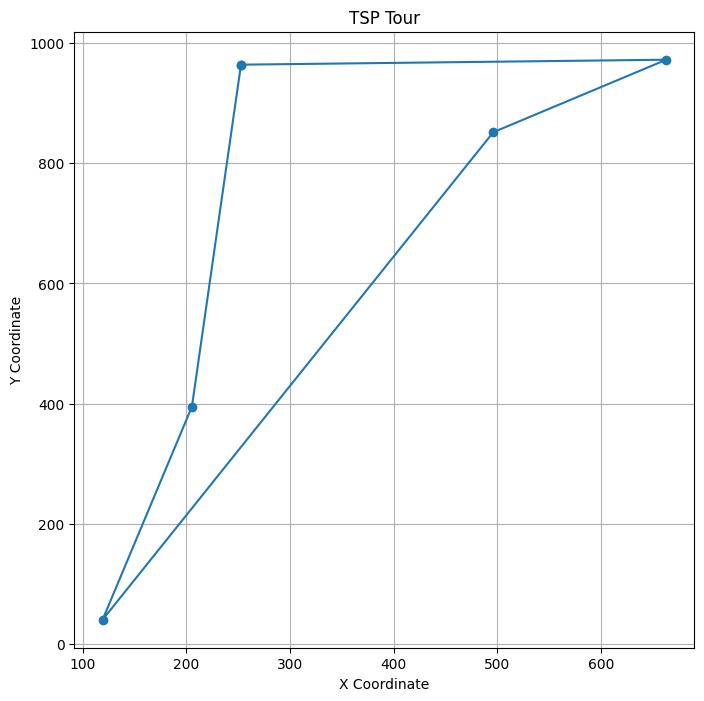

In [8]:
tsp_country.plot_tour(shortest_tour)



Try this algorithm on countries with 4, 6, 8, and 10 cities and plot the time it takes to calculate the answer.

[-7.54803779 -3.47537233 -0.68616781  4.03416762]


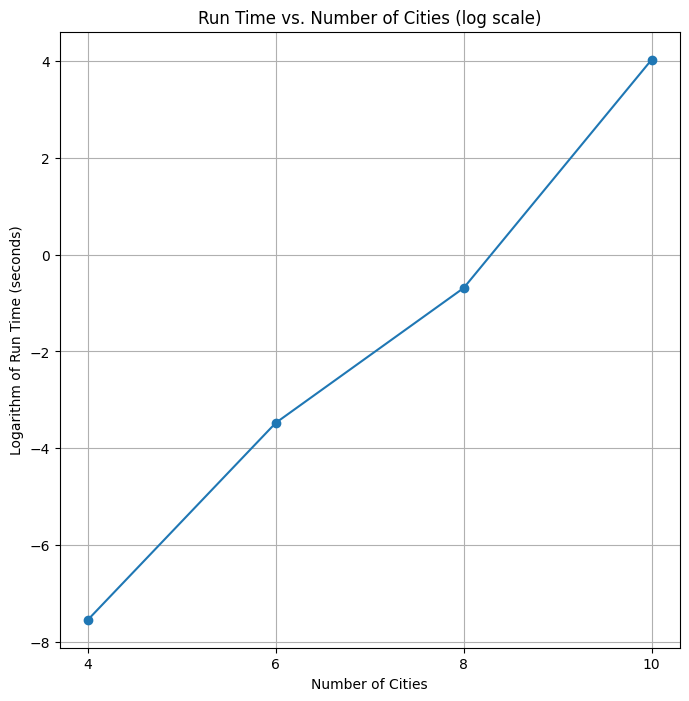

In [12]:
cities_to_test = [4, 6, 8, 10]

run_times = []
city_counts = []

for num_cities in cities_to_test:
    tsp_country = TSP(num_cities)
    start_time = time.time()
    shortest_tour, shortest_length = alltours_tsp(tsp_country)
    end_time = time.time()
    run_time = end_time - start_time
    run_times.append(run_time)
    city_counts.append(num_cities)

print(np.log(run_times))
plt.figure(figsize=(8, 8))
plt.plot(city_counts, np.log(run_times), marker='o')
plt.title('Run Time vs. Number of Cities (log scale)')
plt.xlabel('Number of Cities')
plt.ylabel('Logarithm of Run Time (seconds)')
plt.grid(True)
plt.xticks(city_counts)
plt.show()

## local Algorithms

### Initial Functions (25 Points)

We will create some functions for our initial state and use these functions for our local algorithms later.

- random initial function: Create a feasible tour randomly.

In [13]:
def random_initial(tsp):
    cities_list = list(range(tsp.num_cities))
    random.shuffle(cities_list)
    tour_length = tsp.tour_length(cities_list)
    return cities_list, tour_length

- nearest neighbor initial function: Start at any city; at each step, extend the tour by moving from the previous city to its nearest neighbor that has yet to be visited.

In [14]:
def nearest_neighbor_initial(tsp):
    cities_list = list(range(tsp.num_cities))
    random_start = random.choice(cities_list)
    visited = [random_start]
    unvisited = cities_list.copy()
    unvisited.remove(random_start)

    current_city = random_start
    while unvisited:
        nearest_city = min(unvisited, key=lambda city: tsp.distance(current_city, city))
        visited.append(nearest_city)
        unvisited.remove(nearest_city)
        current_city = nearest_city

    tour_length = tsp.tour_length(visited)
    return visited, tour_length

- repeated nearest neighbor initial function : You can improve nearest neighbor algorithm by running it multiple times with different starting cities and using the best-generated answer.

In [15]:
def repeated_nearest_neighbor_initial(tsp, repetitions=None):
    if repetitions is None:
        repetitions = tsp.num_cities

    best_tour = None
    best_length = float('inf')

    for _ in range(repetitions):
        tour, length = nearest_neighbor_initial(tsp)
        if length < best_length:
            best_length = length
            best_tour = tour

    return best_tour,best_length

Now, try to create a country with 30 cities, apply your repeated_nearest_neighbor_initial function with repetitions of 1, 4, 8, 12, and compare the results.

In [23]:
tsp_country = TSP(num_cities=30)

repetitions_list = [1, 4, 8, 12]

tour_lengths = []

for repetitions in repetitions_list:
    tour, length = repeated_nearest_neighbor_initial(tsp_country, repetitions=repetitions)
    tour_lengths.append(length)

print(tour_lengths)

[4724.828482993579, 4701.800290470539, 4647.723270132633, 4647.723270132633]


Does repetition make our answer optimal?<br>
No, increasing the number of repetitions in the repeated nearest neighbor algorithm does not guarantee an optimal solution. The repeated nearest neighbor algorithm improves the chances of finding a good solution but does not ensure optimality. It may help in avoiding local optima and exploring different initial tours, but the algorithm can still be sensitive to the starting points and the randomness involved in the nearest neighbor heuristic. Therefore, while repetitions can improve the quality of the solution, they do not guarantee optimality.

- beam search initial function: Start with a list of n cities; at each step, extend your semi-tours by moving from their previous cities to their n nearest neighbors and then pick out n semi-tours from these generated semi-tours of length i+1

In [24]:
def beam_search_initial(tsp, n, iterations):
    queue = [random_initial(tsp) for _ in range(n)]
    
    # queue = [nearest_neighbor_initial(tsp) for _ in range(n)]
    # The beam search algorithm heavily depends on the initial set of semi-tours, so a poor initialization can lead to
    # suboptimal results.

    for _ in range(iterations):
        new_queue = []
        for tour, _ in queue:
            for city in tour:
                neighbors = tsp.nearest_neighbor(city, tour)
                for neighbor in neighbors:
                    new_tour = tour[:tour.index(city)] + [neighbor] + tour[tour.index(city) + 1:]
                    new_queue.append((new_tour, tsp.tour_length(new_tour)))

        new_queue.sort(key=lambda x: x[1])
        queue = new_queue[:n]

    best_tour, best_length = queue[0]
    return best_tour, best_length

Now, try to create a country with 30 cities, apply these initial functions, and compare the tour length of these initial tours with each other and the optimal answer (if city_num is low).

In [27]:
tsp_country = TSP(num_cities=30)

random_tour, random_length = random_initial(tsp_country)
nn_tour, nn_length = nearest_neighbor_initial(tsp_country)
repeated_nn_tour, repeated_nn_length = repeated_nearest_neighbor_initial(tsp_country)
beam_tour, beam_length = beam_search_initial(tsp_country, n=5, iterations=10)

print("Random Initial Length:", random_length)
print("Nearest Neighbor Initial Length:", nn_length)
print("Repeated Nearest Neighbor Initial Length:", repeated_nn_length)
print("Beam Search Initial Length:", beam_length)

Random Initial Length: 14925.399294511048
Nearest Neighbor Initial Length: 5173.290898694501
Repeated Nearest Neighbor Initial Length: 4854.309545620621
Beam Search Initial Length: 10650.455721091777


Plot these tours and compare them visually.

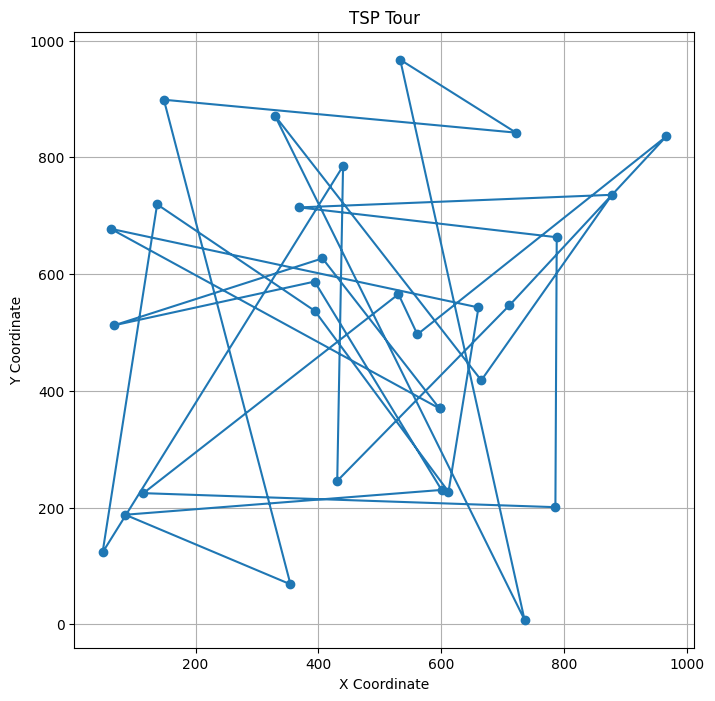

In [28]:
tsp_country.plot_tour(random_tour)

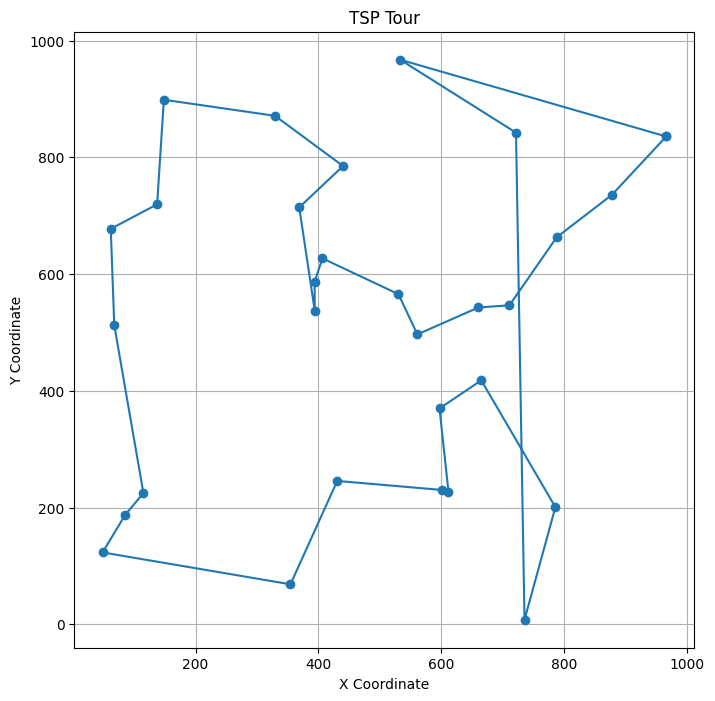

In [29]:
tsp_country.plot_tour(nn_tour)

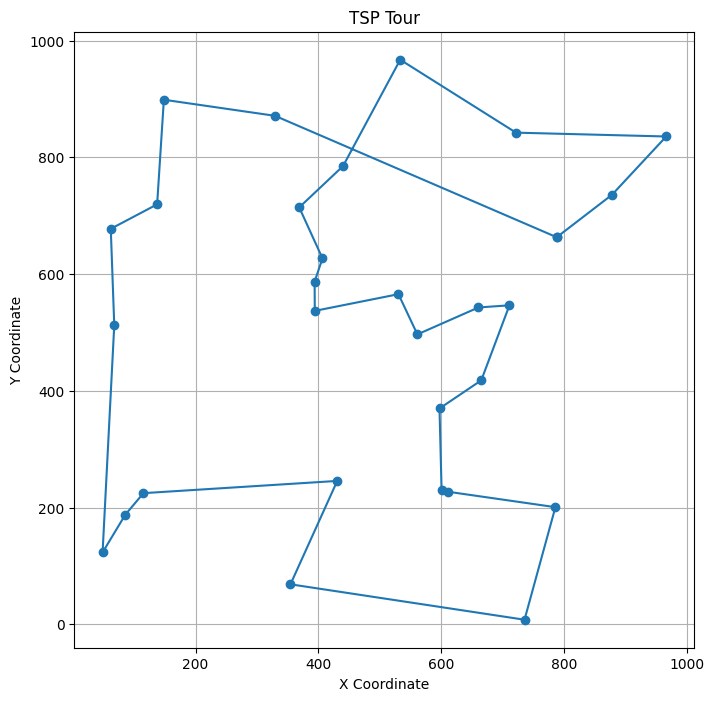

In [30]:
tsp_country.plot_tour(repeated_nn_tour)

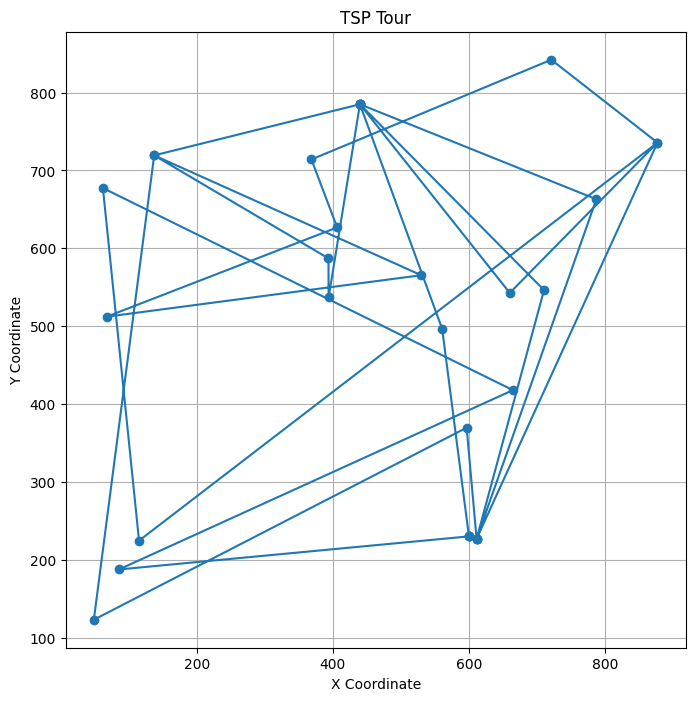

In [31]:
tsp_country.plot_tour(beam_tour)

### LKH (25 Points)

Implement a simplified version of [LKH](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwimj7nFoqCEAxWzh_0HHc98Df4QFnoECCQQAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FLin%25E2%2580%2593Kernighan_heuristic&usg=AOvVaw0G05-wkkun1YAp6zPfWuLd&opi=89978449) for this problem.</br>
- This local search algorithm takes the initial state and improves it over time by swapping a part of the tour sequence.
- In this modified version, we will check every (i,j) pair at each iteration and reverse the tour from index "I" to index "J" if it improves our tour.


In [32]:
def lin_kernighan(tsp, initial, iterations=10):
    tour = initial.copy()
    best_distance = tsp.tour_length(tour)

    for _ in range(iterations):
        improved = False
        for i in range(tsp.num_cities):
            for j in range(i + 2, tsp.num_cities):
                new_tour = tour[:i] + tour[i:j][::-1] + tour[j:]
                new_distance = tsp.tour_length(new_tour)
                if new_distance < best_distance:
                    tour = new_tour
                    best_distance = new_distance
                    improved = True

        if not improved:
            break

    return tour, best_distance

Run this algorithm on a reasonably big country and visualize it.</br>
You can use any initial state in this part.

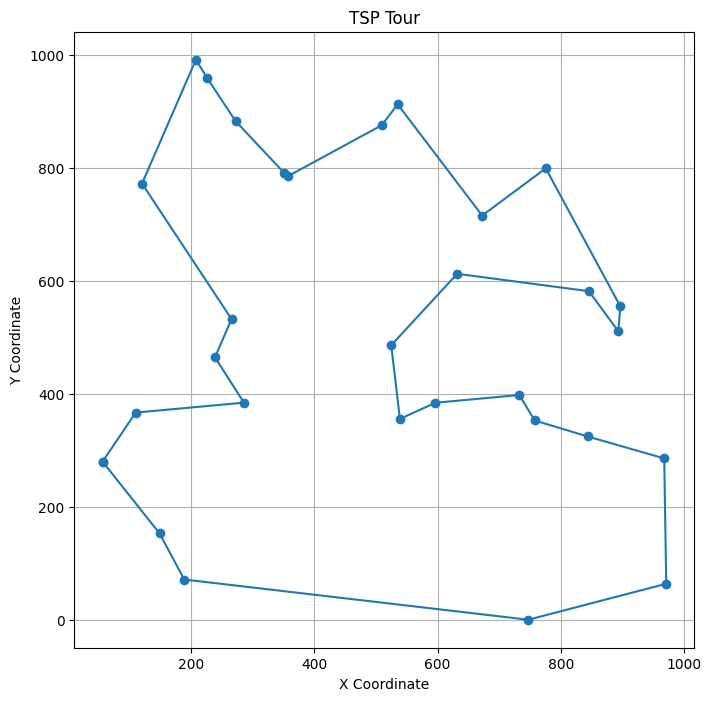

4462.786304329218


In [33]:
tsp_country = TSP(num_cities=30)

initial_tour, initial_length = random_initial(tsp_country)

optimized_tour, optimized_length = lin_kernighan(tsp_country, initial_tour)

tsp_country.plot_tour(optimized_tour)
print(optimized_length)

### Simulated Annealing (25 Points)

Implement simulated annealing for this problem.

In [34]:
def simulated_annealing(tsp, initial, initial_temperature=1000, cooling_rate=0.99, num_iterations=10000):
    current_tour = initial.copy()
    current_length = tsp.tour_length(current_tour)

    best_tour = current_tour.copy()
    best_length = current_length

    temperature = initial_temperature

    for _ in range(num_iterations):
        neighbor_tour = current_tour.copy()
        i, j = random.sample(range(tsp.num_cities), 2)
        neighbor_tour[i:j+1] = reversed(neighbor_tour[i:j+1])
        neighbor_length = tsp.tour_length(neighbor_tour)

        delta_length = neighbor_length - current_length
        if delta_length < 0 or random.random() < math.exp(-delta_length / temperature):
            current_tour = neighbor_tour
            current_length = neighbor_length

        if neighbor_length < best_length:
            best_tour = neighbor_tour
            best_length = neighbor_length

        temperature *= cooling_rate

    return best_tour, best_length

Run this algorithm on a reasonably big country and visualize it.</br>
You can use any initial state in this part.

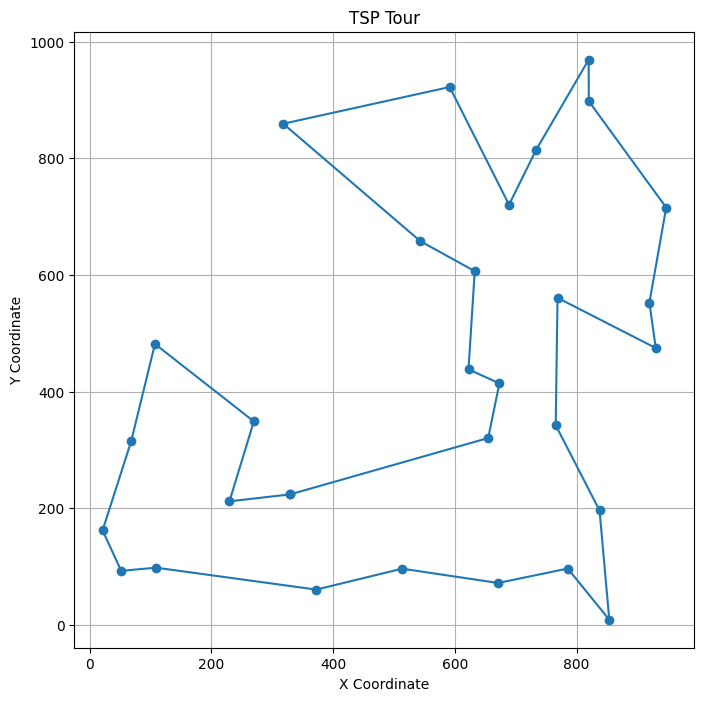

4855.981865743894


In [36]:
tsp_country = TSP(num_cities=30)

initial_tour, initial_length = random_initial(tsp_country)

optimized_tour, optimized_length = simulated_annealing(tsp_country, initial_tour)

tsp_country.plot_tour(optimized_tour)

### Analysis

- The given code can calculate an acceptable approximated answer.
- Use this code to compare your algorithms.

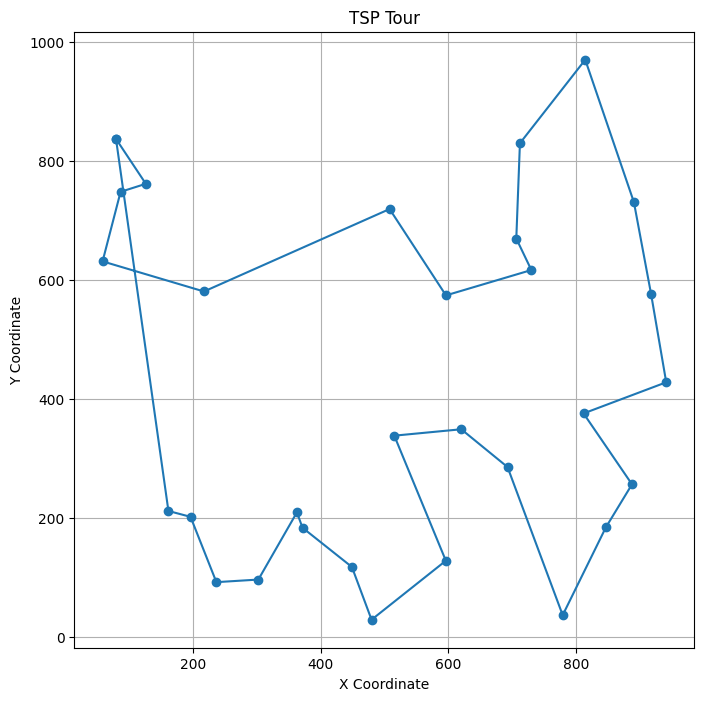

4565.991190616592


In [71]:
tsp_country = TSP(num_cities=30)
distances = np.zeros((30, 30))

for i in range(30):
    for j in range(i + 1, 30):
        dist = tsp_country.distance(i, j)
        distances[i][j] = dist
        distances[j][i] = dist

path = solve_tsp(distances)
tsp_country.plot_tour(path)
print(tsp_country.tour_length(path))

- Analyze the lengths you get from the two algorithms with different initial functions
- Plot these tours and explain the results (results may be inconsistent as they are approximations)<br>
According to the tours plotted below:<br>
With random initialization, simulated annealing finds a shorter tour compared to lkh<br>
With nn initialization, lkh finds a shorter tour compared to simulated annealing<br>
With rnn initialization, lkh finds a shorter tour compared to simulated annealing<br>
With beam search initialization, lkh finds a shorter tour compared to simulated annealing<br>

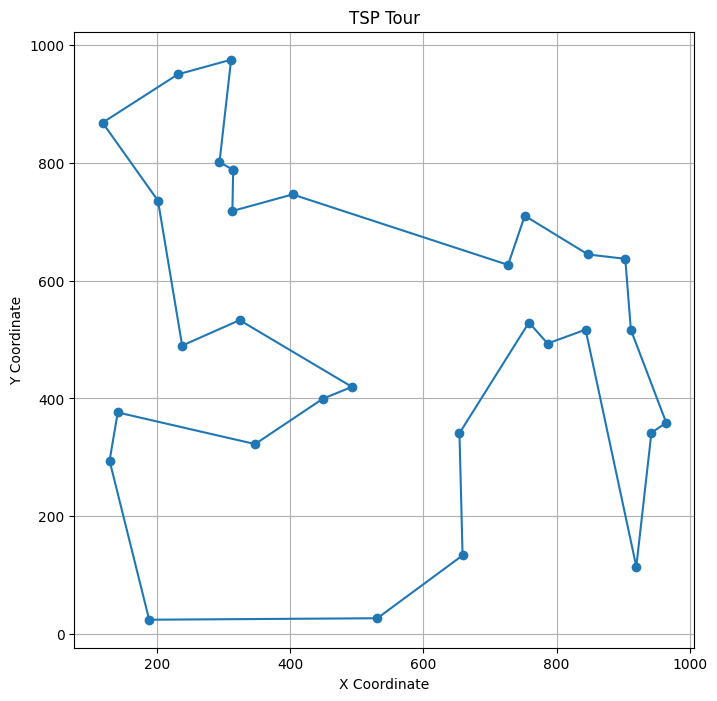

LKH Random: 4635.311273193373


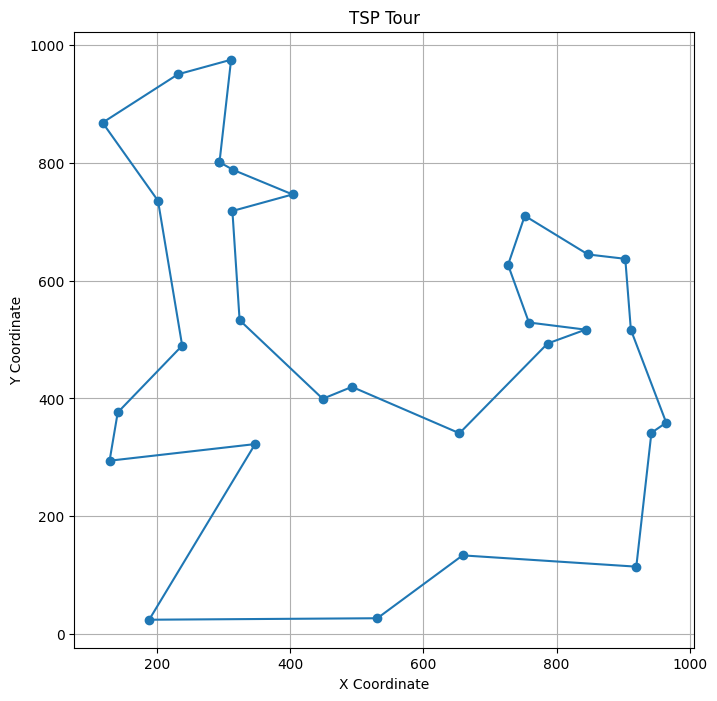

LKH NN: 4432.458571710865


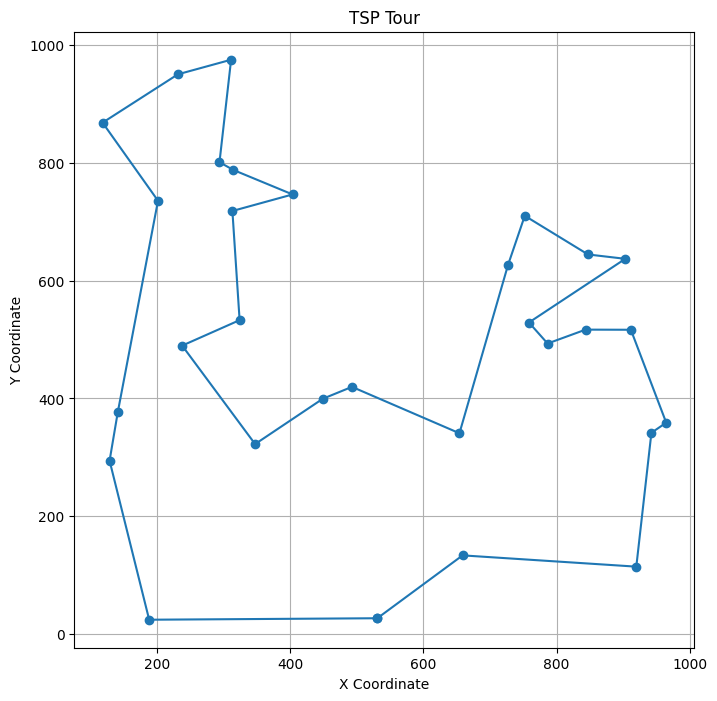

LKH RNN 4435.977713145012


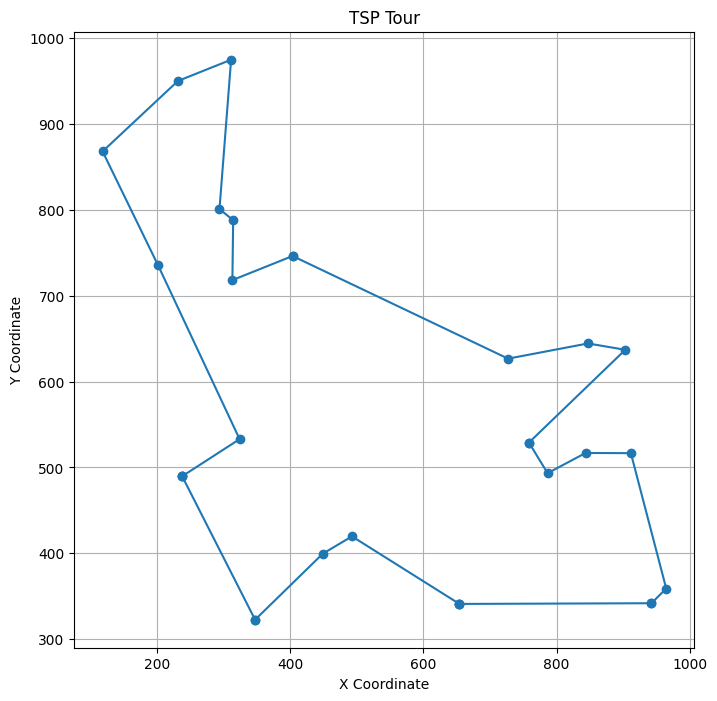

LKH Beam Search: 2992.753062791962


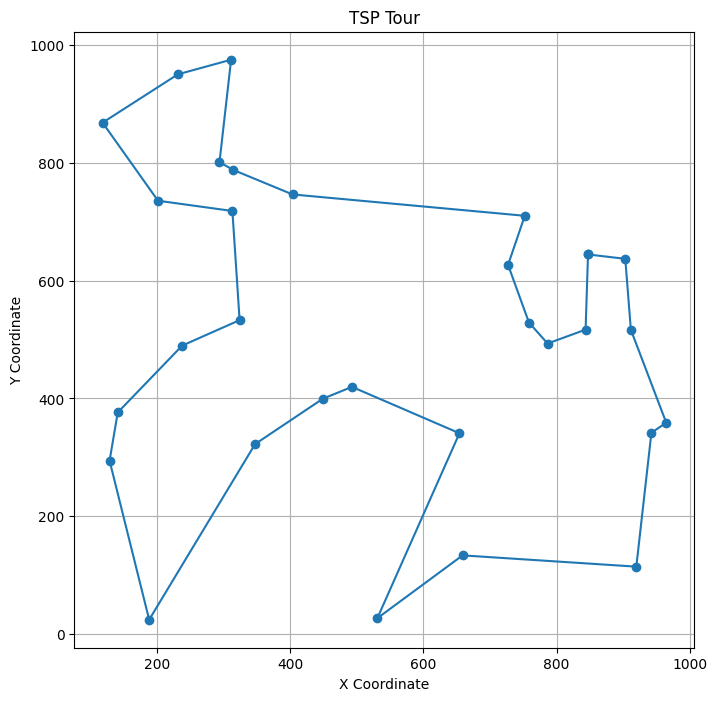

Simulated Annealing Random: 4414.596386490919


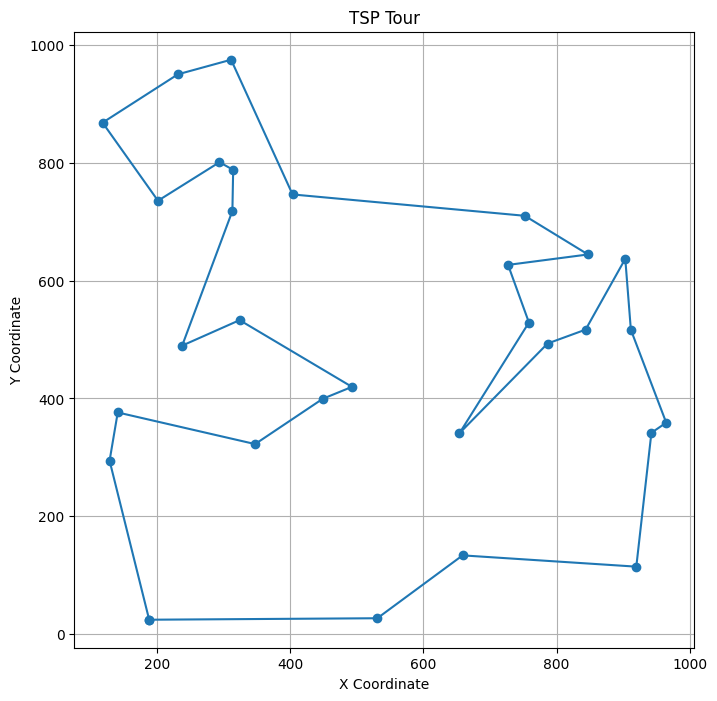

Simulated Annealing NN: 4739.097219505767


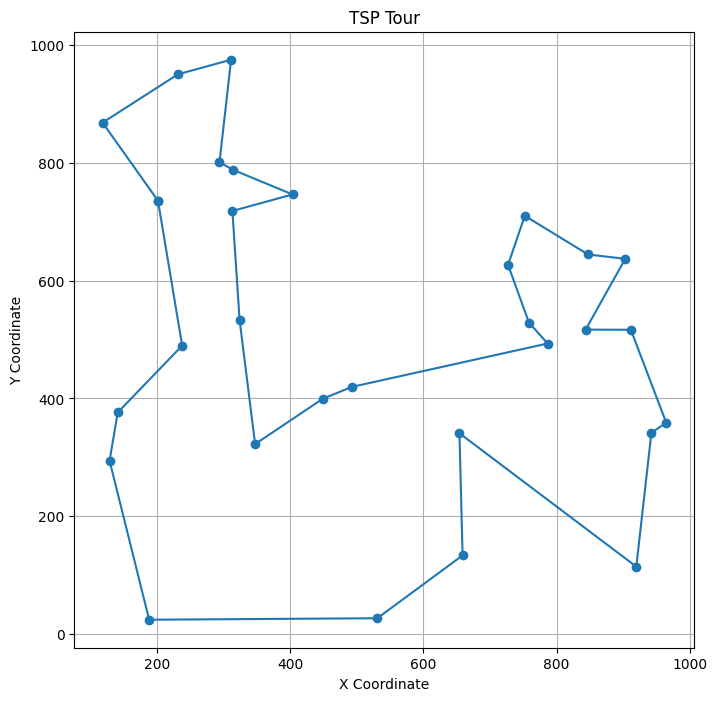

Simulated Annealing RNN 4502.299096841932


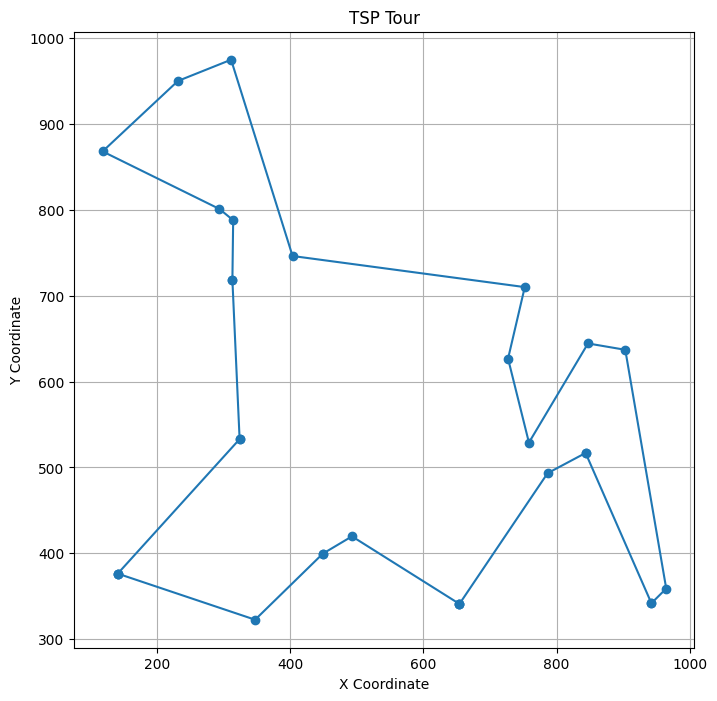

Simulated Annealing Beam Search: 3266.6227002667397


In [74]:
tsp_country = TSP(num_cities=30)

initial_tour_random, initial_length_random = random_initial(tsp_country)
optimized_tour_random, optimized_length_random = lin_kernighan(tsp_country, initial_tour_random)
tsp_country.plot_tour(optimized_tour_random)
print("LKH Random:", optimized_length_random)

initial_tour_nn, initial_length_nn = nearest_neighbor_initial(tsp_country)
optimized_tour_nn, optimized_length_nn = lin_kernighan(tsp_country, initial_tour_nn)
tsp_country.plot_tour(optimized_tour_nn)
print("LKH NN:", optimized_length_nn)

initial_tour_rnn, initial_length_rnn = repeated_nearest_neighbor_initial(tsp_country)
optimized_tour_rnn, optimized_length_rnn = lin_kernighan(tsp_country, initial_tour_rnn)
tsp_country.plot_tour(optimized_tour_rnn)
print("LKH RNN", optimized_length_rnn)

initial_tour_beam, initial_length_beam = beam_search_initial(tsp_country, n=5, iterations=10)
optimized_tour_beam, optimized_length_beam = lin_kernighan(tsp_country, initial_tour_beam)
tsp_country.plot_tour(optimized_tour_beam)
print("LKH Beam Search:", optimized_length_beam)


initial_tour_random, initial_length_random = random_initial(tsp_country)
optimized_tour_random, optimized_length_random = simulated_annealing(tsp_country, initial_tour_random)
tsp_country.plot_tour(optimized_tour_random)
print("Simulated Annealing Random:", optimized_length_random)

initial_tour_nn, initial_length_nn = nearest_neighbor_initial(tsp_country)
optimized_tour_nn, optimized_length_nn = simulated_annealing(tsp_country, initial_tour_nn)
tsp_country.plot_tour(optimized_tour_nn)
print("Simulated Annealing NN:", optimized_length_nn)

initial_tour_rnn, initial_length_rnn = repeated_nearest_neighbor_initial(tsp_country)
optimized_tour_rnn, optimized_length_rnn = simulated_annealing(tsp_country, initial_tour_rnn)
tsp_country.plot_tour(optimized_tour_rnn)
print("Simulated Annealing RNN", optimized_length_rnn)

initial_tour_beam, initial_length_beam = beam_search_initial(tsp_country, n=5, iterations=10)
optimized_tour_beam, optimized_length_beam = simulated_annealing(tsp_country, initial_tour_beam)
tsp_country.plot_tour(optimized_tour_beam)
print("Simulated Annealing Beam Search:", optimized_length_beam)